In [1]:
# this is based largely on the following website content:
# https://carpentries-incubator.github.io/geospatial-python/10-zonal-statistics.html

import rioxarray
import xarray as xr
from xrspatial import zonal_stats
import pandas as pd
from rasterio import features 
import geopandas as gpd
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import IPython.display

In [2]:
cwd = Path.cwd()
zone_shapefile = cwd / 'data/mn_surface_water_drainage_basins.shp'
raster_observations_data = cwd / 'data/AET_2018_07.tif'
raster_simulations_data = cwd / 'data/SWB_AET_output_2018-07.nc'
raster_simulations_epsg = 5070

In [3]:
# read in the zone shapefile and the raster data file
# we're applying 'squeeze' to the raster data file in order to drop the stupid 'band' dimension that otherwise comes up
aet_obs = rioxarray.open_rasterio(raster_observations_data).squeeze()
aet_sim = xr.open_dataset(raster_simulations_data)
zone = gpd.read_file(zone_shapefile)

In [4]:
aet_sim

<xarray.Dataset> Size: 63MB
Dimensions:    (time: 33, y: 688, x: 620)
Coordinates:
  * time       (time) datetime64[ns] 264B 2018-06-30 2018-07-01 ... 2018-08-01
  * y          (y) float64 6kB 2.934e+06 2.933e+06 ... 2.248e+06 2.247e+06
  * x          (x) float64 5kB -1.245e+05 -1.235e+05 ... 4.935e+05 4.945e+05
    crs        int32 4B ...
Data variables:
    actual_et  (time, y, x) float32 56MB ...
    lat        (y, x) float64 3MB ...
    lon        (y, x) float64 3MB ...
Attributes:
    source:              actual_et output from SWB run started on Sep 05 2024...
    executable_version:  version 2.3.3, build 10, Git branch: master, Git com...
    Conventions:         CF-1.6
    history:             Sep 05 2024 13:57:50: Soil-Water-Balance run started.

In [5]:
aet_obs_subset = aet_obs[0:900,3000:4400]

In [6]:
# reproject zone to match the projection of the AET raster data
zone_epsg_4269 = zone.to_crs(aet_obs.rio.crs)

# reproject zone to match prjection of simulated AET raster data
zone_epsg_5070 = zone.to_crs(epsg=raster_simulations_epsg)

In [7]:
#zone_epsg_4269['zone_id'] = [int(s.replace('H','')) for s in zone_epsg_4269.loc[:,'site_no']]
zone_epsg_4269['zone_id'] = zone_epsg_4269.loc[:,'BASIN_INDX'] + 1
zone_epsg_5070['zone_id'] = zone_epsg_5070.loc[:,'BASIN_INDX'] + 1

In [8]:
zone_epsg_4269

,BASIN_INDX,station_nm,site_no,area_calc,geometry,zone_id
0,0,"ST. LOUIS RIVER NEAR SKIBO, MN",04015438,100.843794,"POLYGON ((-91.76904 47.60841, -91.76827 47.608...",1
1,1,"BOIS BRULE RIVER AT BRULE, WI",04025500,117.837260,"POLYGON ((-91.81467 46.46616, -91.81467 46.466...",2
2,2,"STONEY BROOK AT PINE DRIVE NEAR BROOKSTON, MN",04021520,74.284679,"POLYGON ((-92.72605 46.83725, -92.72607 46.836...",3
3,3,"WHITTLESEY CREEK NEAR ASHLAND, WI",040263205,28.258041,"POLYGON ((-91.18201 46.66996, -91.18203 46.669...",4
4,4,"NORTH FISH CREEK NEAR MOQUAH, WI",040263491,79.151705,"POLYGON ((-91.18769 46.62976, -91.18773 46.629...",5
...,...,...,...,...,...,...
65,65,"North Fork Crow River nr Georgeville, CSAH19",H18066001,180.742858,"MULTIPOLYGON (((-94.93522 45.47262, -94.93510 ...",66
66,66,"Wright CD31 nr Montrose, Armitage Rd",H18075003,23.523919,"POLYGON ((-93.90196 45.03475, -93.90209 45.034...",67
67,67,"Rum River nr Milaca, CSAH16",H21021001,582.734221,"POLYGON ((-93.70012 45.87345, -93.70012 45.873...",68
68,68,"Vermillion River nr Vermillion, CSAH85",H38025003,187.250639,"MULTIPOLYGON (((-92.95616 44.67731, -92.95616 ...",69


In [9]:
# xarray-spatial requires a list of geometry and zone_id pairs in a very specific format
# this appears to produce the required list
geom_4269 = zone_epsg_4269[['geometry', 'zone_id']].values.tolist()
geom_5070 = zone_epsg_5070[['geometry', 'zone_id']].values.tolist()

In [10]:
zone_rasterized_4269= features.rasterize(geom_4269, out_shape=aet_obs_subset.shape, transform=aet_obs_subset.rio.transform())
zone_rasterized_5070= features.rasterize(geom_5070, out_shape=aet_sim.actual_et[0,:,:].shape, transform=aet_sim.rio.transform())

In [11]:
zone_rasterized_4269_da = aet_obs_subset.copy()
zone_rasterized_4269_da.data = zone_rasterized_4269

zone_rasterized_5070_da = aet_sim.actual_et[0,:,:].copy()
zone_rasterized_5070_da.data = zone_rasterized_5070

In [12]:
zone_rasterized_5070_da

<xarray.DataArray 'actual_et' (y: 688, x: 620)> Size: 427kB
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
Coordinates:
    time     datetime64[ns] 8B 2018-06-30
  * y        (y) float64 6kB 2.934e+06 2.933e+06 ... 2.248e+06 2.247e+06
  * x        (x) float64 5kB -1.245e+05 -1.235e+05 ... 4.935e+05 4.945e+05
    crs      int32 4B ...
Attributes:
    units:         inches
    valid_min:     0.0
    valid_max:     0.40314275
    valid_range:   [0.         0.40314275]
    grid_mapping:  crs

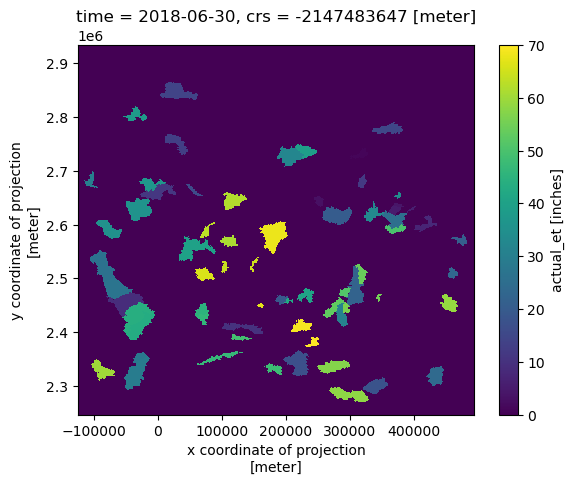

In [13]:
zone_rasterized_5070_da.plot()

In [14]:
aet_obs_subset.data[ aet_obs_subset.data < 0] = np.nan
obsdf = aet_obs_subset * 31

In [18]:
simdf = aet_sim.actual_et[:,:,:].sum(dim='time') * 25.4

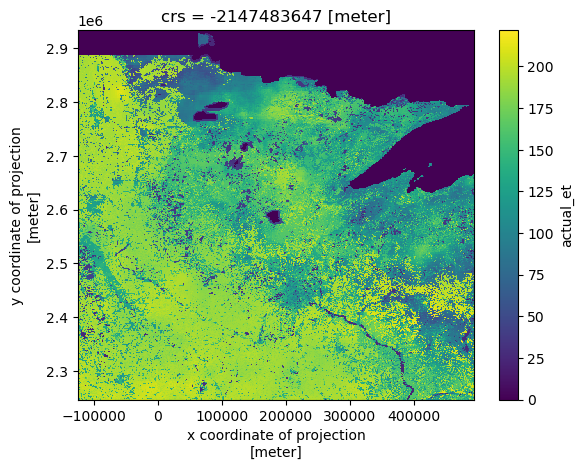

In [19]:
simdf.plot()

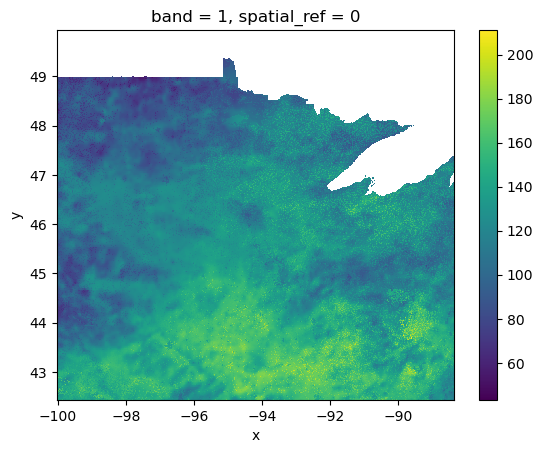

In [16]:
obsdf.plot()

In [ ]:
df_obs = zonal_stats(zone_rasterized_4269_da, aet_obs_subset)
df_sim = zonal_stats(zone_rasterized_5070_da, aet_sim.actual_et.sum(dim='time')*25.4)
#IPython.display.HTML(df_obs.to_html())

In [ ]:
df_obs

In [ ]:
df_sim

In [ ]:
plt.scatter(df_obs['mean'], df_sim['mean'])

In [ ]:
df_merged = pd.merge(zone_epsg_4269, df, left_on='zone_id', right_on='zone')

In [ ]:
df_merged